In [1]:
#importan librerias

#Librerias base
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import os
import cv2

from glob import glob 
#Librerias de modelado
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

2024-06-19 21:12:47.615670: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Funcion para leer las imagenes de un folder
def load_folder_with_label(folder_path,label, size = (128,128)):
  files = glob(os.path.join(folder_path,"*"))
  X = list(map(plt.imread, files))
  X = [cv2.resize(img,size) for img in X]
  y = [label] * len(X)
  return X,y 

In [3]:
image_size = (128,128)

In [4]:
#Cargamos los datos de entrenamiento de la clase 0 y clase 1
X_0, y_0 = load_folder_with_label("ok_images_train", 1, size = image_size)
X_1, y_1 = load_folder_with_label("nok_images_train", 0, size = image_size)
X = X_0 + X_1
y = y_0 + y_1
del X_0 , X_1, y_0 , y_1

In [5]:
#Cargamos los datos de validacion de la clase 0 y clase 1
X_validation_0, y_validation_0 = load_folder_with_label("ok_images_val", 1, size = image_size)
X_validation_1, y_validation_1 = load_folder_with_label("nok_images_val", 0, size = image_size)
X_validation = X_validation_0 + X_validation_1
y_validation = y_validation_0 + y_validation_1
del X_validation_0 , X_validation_1, y_validation_0 , y_validation_1

In [6]:
#Cargamos los datos de test de la clase 0 y clase 1
X_test_0, y_test_0 = load_folder_with_label("ok_images_test", 1, size = image_size)
X_test_1, y_test_1 = load_folder_with_label("nok_images_test", 0, size = image_size)
X_test = X_test_0 + X_test_1
y_test = y_test_0 + y_test_1
del X_test_0 , X_test_1, y_test_0 , y_test_1

In [7]:
#codificamos la target
lbl = LabelEncoder()
lbl.fit(y + y_validation + y_test)

LabelEncoder()

In [8]:
y = lbl.transform(y)
y_validation = lbl.transform(y_validation)
y_test = lbl.transform(y_test)
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

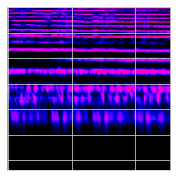

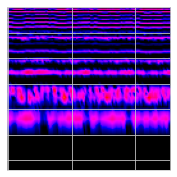

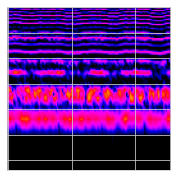

In [9]:
#Vistazo a nuestro dataset
for img in X[:3]:
  plt.figure(figsize = (3,3))
  plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
  plt.imshow(img, cmap = "gray")
  plt.show()

In [10]:
X = np.array(X)
X_validation = np.array(X_validation)
X_test = np.array(X_test)

In [11]:
X.shape

(560, 128, 128, 4)

In [12]:
X_train = X
y_train = y

In [13]:
y.shape

(560,)

In [14]:
# Crear el modelo secuencial
model = Sequential()

#Primer capa
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(image_size[0], image_size[1], 4)))
model.add(MaxPooling2D(pool_size=(2,2)))

#Segunda capa
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Tercera capa
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Aplanamiento
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu'))


# Capa densa de salida con una neurona y activación 'sigmoid' para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
#Resumen de la arquitectura del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 829,233 (3.16 MB)

 Trainable params: 829,233 (3.16 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
class_weights = {0: 1.5, 1: 1.0}

# Compilar el modelo con el optimizador 'adam', la función de pérdida BinaryCrossentropy y métricas de precisión
model.compile(optimizer='adam',
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])
# Entrenar el modelo con los datos de entrenamiento y validar con los datos de prueba

history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_validation, y_validation), class_weight=class_weights)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 378ms/step - accuracy: 0.5275 - loss: 0.8882 - val_accuracy: 0.5000 - val_loss: 0.7077
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step - accuracy: 0.4481 - loss: 0.8469 - val_accuracy: 0.5000 - val_loss: 0.7408
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - accuracy: 0.5020 - loss: 0.8484 - val_accuracy: 0.5000 - val_loss: 0.6599
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 424ms/step - accuracy: 0.4934 - loss: 0.7915 - val_accuracy: 0.6250 - val_loss: 0.6193
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 400ms/step - accuracy: 0.6029 - loss: 0.7626 - val_accuracy: 0.7250 - val_loss: 0.6074
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step - accuracy: 0.6280 - loss: 0.7473 - val_accuracy: 0.6250 - val_loss: 0.6061
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 342ms/step - accuracy: 0.6142 - loss: 0.6912 - val_accuracy: 0.6625 - val_loss: 0.5922
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 362ms/step - accuracy: 0.6756 - loss: 0.7145 - val_accuracy: 0

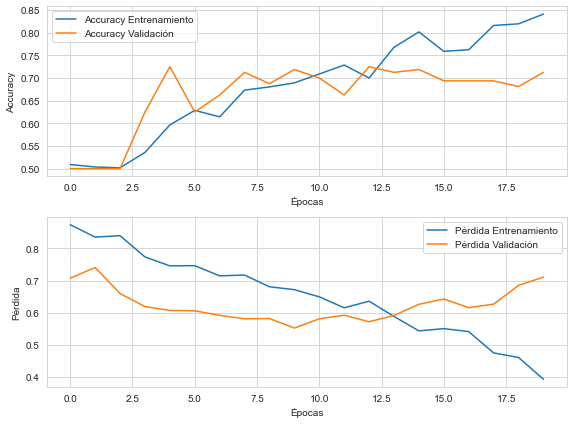

In [17]:
# Obtén los datos del historial
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crea la figura y los subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Gráfica de accuracy
ax1.plot(accuracy, label='Accuracy Entrenamiento')
ax1.plot(val_accuracy, label='Accuracy Validación')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Gráfica de pérdida
ax2.plot(loss, label='Pérdida Entrenamiento')
ax2.plot(val_loss, label='Pérdida Validación')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Pérdida')
# plt.ylim(None,.8)
ax2.legend()

# Ajusta los márgenes y espacios entre subplots
plt.tight_layout()

# Muestra las gráficas
plt.show()

In [18]:
y_proba_train = model.predict(X_train)
y_pred_train = y_proba_train.round().astype(int)
y_proba_test = model.predict(X_test)
y_pred_test = y_proba_test.round().astype(int)
y_proba_validation = model.predict(X_validation)
y_pred_validation = y_proba_validation.round().astype(int)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


In [19]:
lbl = LabelEncoder()
target_names = ['class 1', 'class 0']
#Class 0 = NOK
#Class 1 = OK

In [29]:
print("Train sample \n", classification_report(y_train, y_pred_train, target_names = target_names))
print("Validation sample \n", classification_report(y_validation, y_pred_validation, target_names = target_names))
print("Test sample \n", classification_report(y_test, y_pred_test, target_names = target_names))

Train sample 
               precision    recall  f1-score   support

     class 1       0.91      0.94      0.92       280
     class 0       0.94      0.90      0.92       280

    accuracy                           0.92       560
   macro avg       0.92      0.92      0.92       560
weighted avg       0.92      0.92      0.92       560

Validation sample 
               precision    recall  f1-score   support

     class 1       0.75      0.64      0.69        80
     class 0       0.68      0.79      0.73        80

    accuracy                           0.71       160
   macro avg       0.72      0.71      0.71       160
weighted avg       0.72      0.71      0.71       160

Test sample 
               precision    recall  f1-score   support

     class 1       0.70      0.70      0.70        40
     class 0       0.70      0.70      0.70        40

    accuracy                           0.70        80
   macro avg       0.70      0.70      0.70        80
weighted avg       0.70  

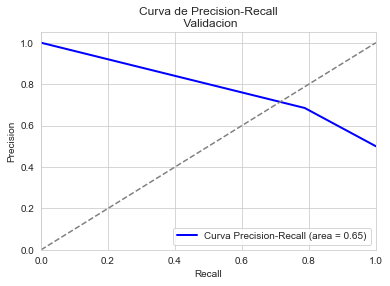

In [21]:
precision, recall, thresholds = precision_recall_curve(y_validation, y_pred_validation)

auc_pr = average_precision_score(y_validation, y_pred_validation)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'Curva Precision-Recall (area = {auc_pr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precision-Recall\n Validacion')

plt.legend(loc="lower right")
plt.show()

In [22]:
!pip install -q scikit-plot
import scikitplot as skplt

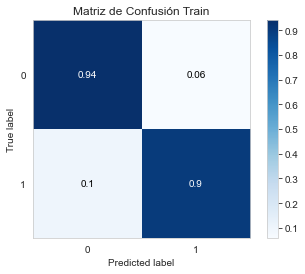

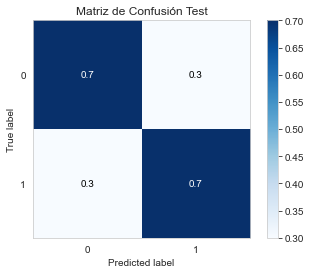

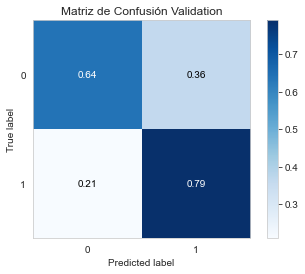

In [23]:
# Gráfico de Matriz de Confusión
skplt.metrics.plot_confusion_matrix(y_train, y_pred_train, normalize=True)
plt.title('Matriz de Confusión Train')

skplt.metrics.plot_confusion_matrix(y_validation, y_pred_validation, normalize=True)
plt.title('Matriz de Confusión Validation')

skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True)
plt.title('Matriz de Confusión Test')


plt.show() 

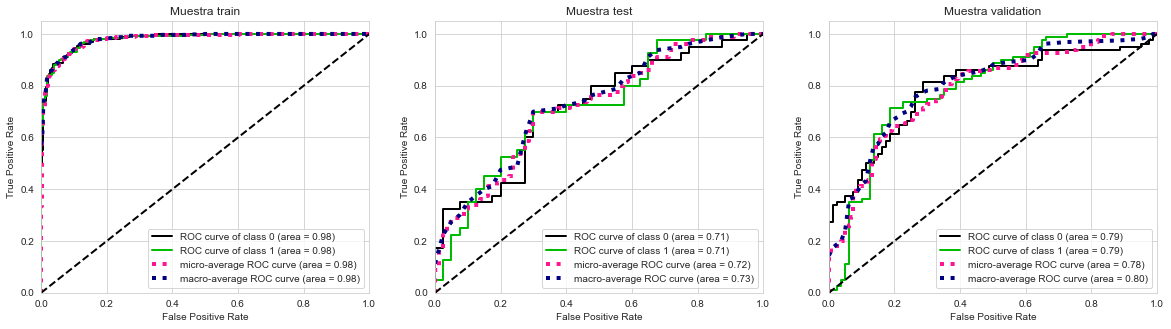

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

skplt.metrics.plot_roc(y_train, np.column_stack((1-y_proba_train, y_proba_train)), ax=axes[0])
axes[0].set_title("Muestra train")

skplt.metrics.plot_roc(y_test, np.column_stack((1-y_proba_test, y_proba_test)), ax=axes[1])
axes[1].set_title("Muestra test")

skplt.metrics.plot_roc(y_validation, np.column_stack((1-y_proba_validation, y_proba_validation)), ax=axes[2])
axes[2].set_title("Muestra validation")
axes[2].legend(loc="lower right")


Grad-CAM en Keras (en proceso)

In [25]:
import keras
def get_grad_cam(model, img_array, layer_name):
    grad_model = keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    
    grads = tape.gradient(loss, conv_outputs)
    
    casted_conv_outputs = tf.cast(conv_outputs > 0, "float32")
    casted_grads = tf.cast(grads > 0, "float32")
    guided_grads = casted_conv_outputs * casted_grads * grads
    
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]
    
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
    
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]
    
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    cam = cv2.resize(cam, (img_array.shape[2], img_array.shape[1]))
    
    return cam

In [26]:
imagen_prueba = X_test[38]
imagen_prueba = np.expand_dims(imagen_prueba, axis=0)
imagen_prueba.shape

(1, 128, 128, 4)

In [27]:
layer_name = 'conv2d'  #nombre de la última capa convolucional

#decode_predictions = keras.applications.xception.decode_predictions


pred = model.predict(imagen_prueba)
pred
#print("Predicted:", decode_predictions(pred, top=1)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[0.9507547]], dtype=float32)

In [28]:
heatmap = get_grad_cam(model, imagen_prueba, layer_name)

ValueError: The layer sequential has never been called and thus has no defined output.

In [ ]:
plt.matshow(heatmap)
plt.show()

In [ ]:
#https://keras.io/examples/vision/grad_cam/